In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Github/

In [ ]:
%cd Pandas4x4-ANN

This notebook is dedicated to the exploration of optimal optimization algorithms, specifically focusing on four main contenders: Adam, AdamW, Experimental SGD, and Lion. To facilitate a comprehensive evaluation, we configured the ConvNeXtLarge architecture. To expedite the experimentation process, we intentionally set a relatively low value for the training epochs and early stopping patience.

### Import Libraries


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [4]:
# Import some other useful libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data = np.load('/kaggle/input/challenge1/dataset.npz', allow_pickle=True)
lst = data.files
X = data[lst[0]]
y = data[lst[1]]

# Convert values in data to int
X = X.astype(int)

### Create train and validation sets

In [6]:
# Normalize data to the range [0, 1]
X_train_val = (X / 255).astype('float32')

# Create a mapping from label string to values
map = {'healthy':0 , 'unhealthy':1}

# Map labels from string to the corresponding encoding
int_labels = np.array([map[label.decode()] for label in y])

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(int_labels)


# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

del X_train_val, y_train_val

In [7]:
#Upload the ConvNeXtLarge architecture 
convnext = tf.keras.applications.ConvNeXtLarge(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
    #pooling='avg',
    classes=2,
    classifier_activation='softmax',
)
convnext.trainable = False

785596384/785596384 [==============================] - 5s 0us/step


In [8]:
import keras_cv.layers as kcvl

def build_convnext_with_augmentation(input_shape=(96, 96, 3)):
    tf.random.set_seed(seed)

    img_augmentation = tf.keras.Sequential(
    [
        kcvl.RandAugment(
            # parameters set as in the paper
            value_range = (0,1),
            augmentations_per_image=3,
            magnitude=0.3,
            magnitude_stddev=0.15,
            rate=0.9090909090909091,
            geometric=True,
            seed=seed),
        tfkl.RandomFlip(),
        tfkl.RandomZoom(height_factor = (-0.15,0.2), width_factor = (-0.15,0.2)),
        tfkl.RandomRotation(factor= 0.5),
    ],
    name="img_augmentation",)

    inputs = tfk.Input(shape=input_shape)
    augmentation = img_augmentation(inputs)
    augmented_255 = tf.cast(augmentation* 255, tf.uint8)

    x1 = convnext(augmented_255)
    x2 = tfkl.GlobalAveragePooling2D(name="avg_pool")(x1)
    x3 = tfkl.BatchNormalization()(x2)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    intermediate1 = tfkl.Dense(1024, activation=tf.keras.activations.swish)(x3)
    intermediate2 = tfkl.Dense(64, activation=tf.keras.activations.swish)(intermediate1)

    outputs = tfkl.Dense(2, activation='softmax')(intermediate2)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

    # Return the model
    return model

Using TensorFlow backend


### Plot of History and LR Scheduler

In [9]:
from tensorflow.keras.callbacks import LearningRateScheduler
'''To enhance test set accuracy and improve stability, generalization, and convergence, we adopted an exponential learning rate decay strategy.
   Here, 'lr' represents the current learning rate, '-0.0015' is the decay rate, and epoch = 50 is the starting epoch for applying the exponential decay.
'''

def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr
    else:
        return lr * tf.math.exp(-0.0015)

## Adam + Exp Decay


In [27]:
#Start the analisys on Adam optimizer
tl_model = build_convnext_with_augmentation()

In [28]:
# Compile the model with Adam optimizer and Exponential LR Decay
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay= 1.0)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
lr_schedule = LearningRateScheduler(lr_scheduler)

In [29]:
# Train the model
adam_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 500,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True), lr_schedule]
).history

Epoch 1/500
345/345 [==============================] - 101s 213ms/step - loss: 0.5988 - accuracy: 0.7180 - val_loss: 0.4907 - val_accuracy: 0.7549 - lr: 0.0010
Epoch 2/500
345/345 [==============================] - 64s 185ms/step - loss: 0.4769 - accuracy: 0.7613 - val_loss: 0.4218 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 3/500
345/345 [==============================] - 63s 183ms/step - loss: 0.4635 - accuracy: 0.7778 - val_loss: 0.4353 - val_accuracy: 0.7680 - lr: 0.0010
Epoch 4/500
345/345 [==============================] - 63s 183ms/step - loss: 0.4392 - accuracy: 0.7910 - val_loss: 0.4693 - val_accuracy: 0.7843 - lr: 0.0010
Epoch 5/500
345/345 [==============================] - 63s 182ms/step - loss: 0.4417 - accuracy: 0.7810 - val_loss: 0.4619 - val_accuracy: 0.7794 - lr: 0.0010
Epoch 6/500
345/345 [==============================] - 63s 183ms/step - loss: 0.4513 - accuracy: 0.7841 - val_loss: 0.5036 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 7/500
345/345 [========================

In [30]:
# Save the history to a file
np.save('adam_history', adam_history)

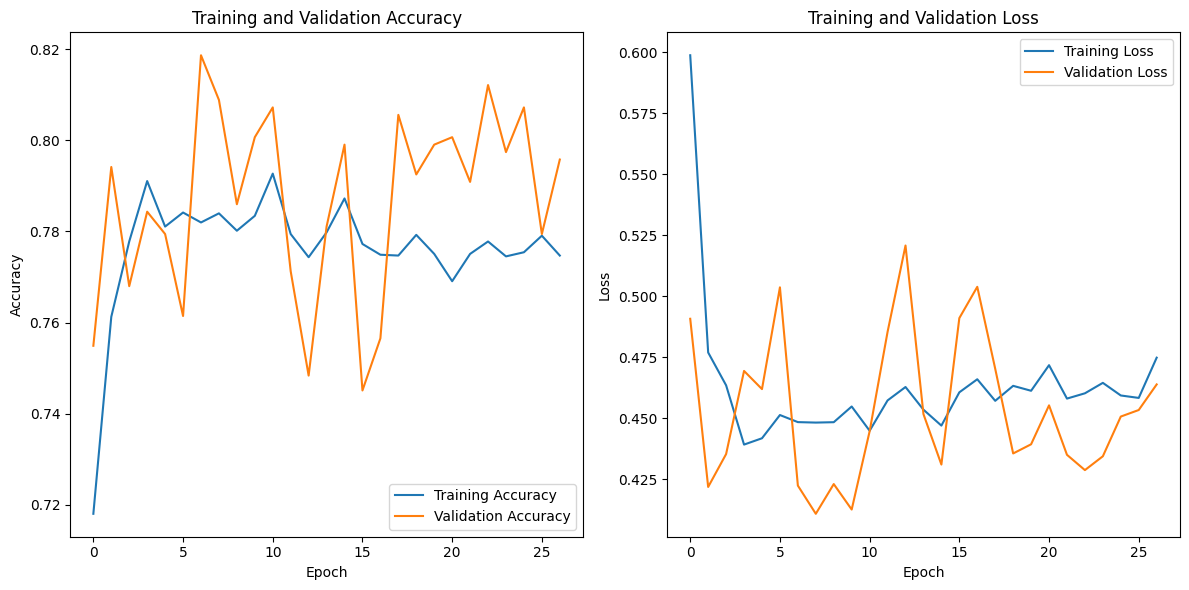

In [31]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(adam_history['accuracy'], label='Training Accuracy')
plt.plot(adam_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(adam_history['loss'], label='Training Loss')
plt.plot(adam_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
val_loss = []
val_accuracy = []
train_loss = []
train_accuracy = []

last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

print("Last model has reached")
print("Train loss: ", last_train_loss)
print("Train accuracy: ", last_train_accuracy)
print("Validation loss: ", last_val_loss)
print("Validation accuracy: ", last_val_accuracy)

173/173 [==============================] - 52s 300ms/step - loss: 0.4044 - accuracy: 0.8150
Last model has reached
Train loss:  0.40441882610321045
Train accuracy:  0.8149963617324829
Validation loss:  0.4470120072364807
Validation accuracy:  0.7924836874008179


In [33]:
del tl_model

## AdamW + Exp Decay


In [24]:
tl_model = build_convnext_with_augmentation()

In [25]:
# Compile the model with Adam optimizer and Exponential LR Decay
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, weight_decay= 1.0)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
lr_schedule = LearningRateScheduler(lr_scheduler)

In [26]:
# Train the model
adamw_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 50,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True), lr_schedule]
).history

Epoch 1/50
345/345 [==============================] - 111s 242ms/step - loss: 0.5936 - accuracy: 0.7090 - val_loss: 0.4572 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 2/50
345/345 [==============================] - 66s 191ms/step - loss: 0.4686 - accuracy: 0.7732 - val_loss: 0.4186 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 3/50
345/345 [==============================] - 66s 192ms/step - loss: 0.4617 - accuracy: 0.7771 - val_loss: 0.4371 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 4/50
345/345 [==============================] - 67s 193ms/step - loss: 0.4549 - accuracy: 0.7890 - val_loss: 0.4989 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 5/50
345/345 [==============================] - 66s 191ms/step - loss: 0.4459 - accuracy: 0.7903 - val_loss: 0.4286 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 6/50
345/345 [==============================] - 66s 192ms/step - loss: 0.4540 - accuracy: 0.7843 - val_loss: 0.5147 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 7/50
345/345 [==============================]

In [27]:
# Save the history to a file
np.save('adamw_history', adamw_history)

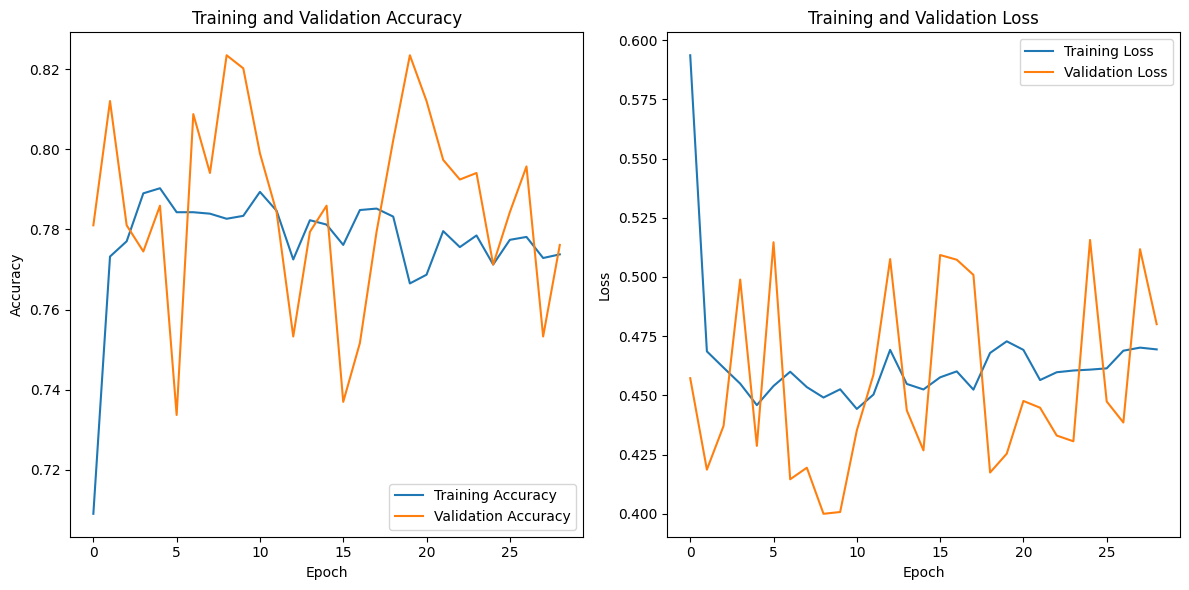

In [28]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(adamw_history['accuracy'], label='Training Accuracy')
plt.plot(adamw_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(adamw_history['loss'], label='Training Loss')
plt.plot(adamw_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
'''The error is caused whenever you develop one of the optimization algorithms before the Adam one'''

last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

print("Last model has reached")
print("Train loss: ", last_train_loss)
print("Train accuracy: ", last_train_accuracy)
print("Validation loss: ", last_val_loss)
print("Validation accuracy: ", last_val_accuracy)

173/173 [==============================] - 55s 316ms/step - loss: 0.3717 - accuracy: 0.8333


NameError: name 'val_loss' is not defined

In [19]:
del tl_model

## Lion + Exp Decay - batch_size: 128





In [13]:
tl_model = build_convnext_with_augmentation()

In [14]:
# Compile the model with Adam optimizer and Exponential LR Decay
optimizer = tf.keras.optimizers.Lion(learning_rate=2.5e-4, weight_decay=5.0)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
lr_schedule = LearningRateScheduler(lr_scheduler)

In [15]:
# Train the model
lion64_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 128,
    epochs = 35,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True), lr_schedule]
).history

Epoch 1/35
44/44 [==============================] - 108s 2s/step - loss: 0.5239 - accuracy: 0.7395 - val_loss: 0.5272 - val_accuracy: 0.7337 - lr: 2.5000e-04
Epoch 2/35
44/44 [==============================] - 54s 1s/step - loss: 0.4444 - accuracy: 0.7889 - val_loss: 0.3814 - val_accuracy: 0.8301 - lr: 2.5000e-04
Epoch 3/35
44/44 [==============================] - 55s 1s/step - loss: 0.4139 - accuracy: 0.8068 - val_loss: 0.4465 - val_accuracy: 0.7843 - lr: 2.5000e-04
Epoch 4/35
44/44 [==============================] - 55s 1s/step - loss: 0.3931 - accuracy: 0.8204 - val_loss: 0.4380 - val_accuracy: 0.8072 - lr: 2.5000e-04
Epoch 5/35
44/44 [==============================] - 55s 1s/step - loss: 0.3846 - accuracy: 0.8204 - val_loss: 0.4198 - val_accuracy: 0.8137 - lr: 2.5000e-04
Epoch 6/35
44/44 [==============================] - 55s 1s/step - loss: 0.3825 - accuracy: 0.8175 - val_loss: 0.3996 - val_accuracy: 0.8219 - lr: 2.5000e-04
Epoch 7/35
44/44 [==============================] - 55s 1

In [16]:
# Save the history to a file
np.save('lion64_history', lion64_history)

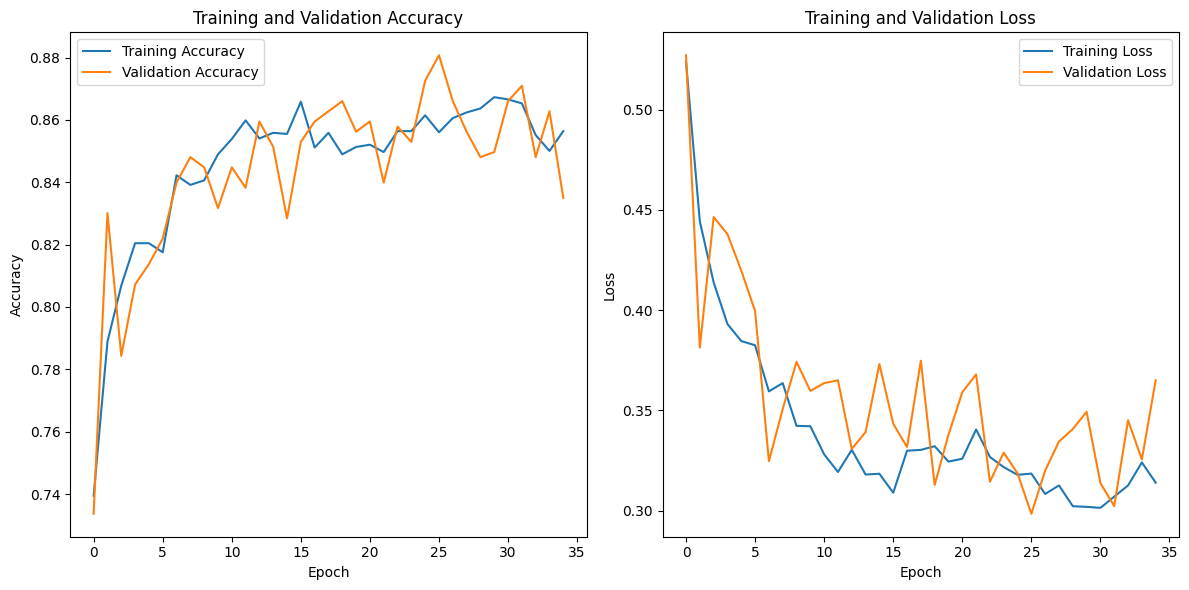

In [17]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(lion64_history['accuracy'], label='Training Accuracy')
plt.plot(lion64_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(lion64_history['loss'], label='Training Loss')
plt.plot(lion64_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

print("Last model has reached")
print("Train loss: ", last_train_loss)
print("Train accuracy: ", last_train_accuracy)
print("Validation loss: ", last_val_loss)
print("Validation accuracy: ", last_val_accuracy)

173/173 [==============================] - 52s 299ms/step - loss: 0.3008 - accuracy: 0.8633


NameError: name 'val_loss' is not defined

In [ ]:
del tl_model

## SGD + Exp Decay


In [21]:
tl_model = build_convnext_with_augmentation()

In [22]:
# Compile the model with Adam optimizer and Exponential LR Decay
optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=1e-4, momentum=0.9)
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])
lr_schedule = LearningRateScheduler(lr_scheduler)

In [23]:
# Train the model
sgd_history = tl_model.fit(
    x = X_train, # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 32,
    epochs = 35,
    validation_data = (X_val, y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True), lr_schedule]
).history

Epoch 1/35
173/173 [==============================] - 90s 379ms/step - loss: 0.7263 - accuracy: 0.5365 - val_loss: 0.6905 - val_accuracy: 0.5670 - lr: 1.0000e-04
Epoch 2/35
173/173 [==============================] - 59s 340ms/step - loss: 0.6480 - accuracy: 0.6309 - val_loss: 0.6316 - val_accuracy: 0.6258 - lr: 1.0000e-04
Epoch 3/35
173/173 [==============================] - 60s 348ms/step - loss: 0.6031 - accuracy: 0.6710 - val_loss: 0.6204 - val_accuracy: 0.6569 - lr: 1.0000e-04
Epoch 4/35
173/173 [==============================] - 60s 349ms/step - loss: 0.5749 - accuracy: 0.6923 - val_loss: 0.5912 - val_accuracy: 0.6699 - lr: 1.0000e-04
Epoch 5/35
173/173 [==============================] - 60s 348ms/step - loss: 0.5599 - accuracy: 0.7077 - val_loss: 0.5824 - val_accuracy: 0.6683 - lr: 1.0000e-04
Epoch 6/35
173/173 [==============================] - 61s 352ms/step - loss: 0.5412 - accuracy: 0.7304 - val_loss: 0.5396 - val_accuracy: 0.7304 - lr: 1.0000e-04
Epoch 7/35
173/173 [========

In [24]:
# Save the history to a file
np.save('sgd_history', sgd_history)

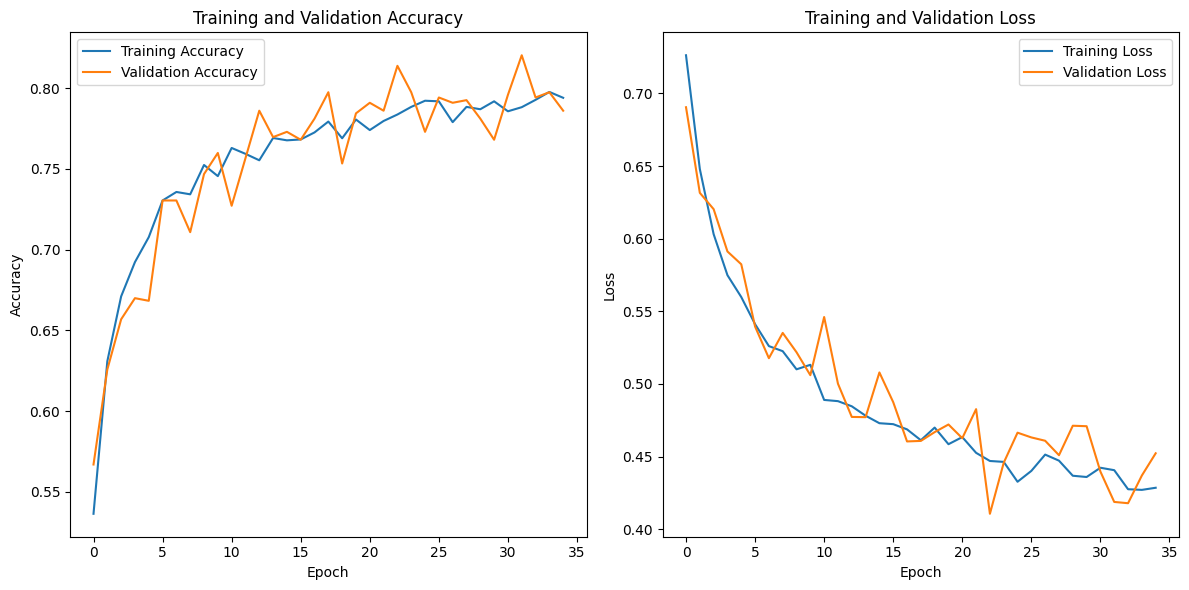

In [25]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(sgd_history['accuracy'], label='Training Accuracy')
plt.plot(sgd_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(sgd_history['loss'], label='Training Loss')
plt.plot(sgd_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
last_val_loss, last_val_accuracy = tl_model.evaluate(X_val, y_val)
last_train_loss, last_train_accuracy = tl_model.evaluate(X_train, y_train)

val_loss.append(last_val_loss)
val_accuracy.append(last_val_accuracy)
train_loss.append(last_train_loss)
train_accuracy.append(last_train_accuracy)

print("Last model has reached")
print("Train loss: ", last_train_loss)
print("Train accuracy: ", last_train_accuracy)
print("Validation loss: ", last_val_loss)
print("Validation accuracy: ", last_val_accuracy)

173/173 [==============================] - 52s 300ms/step - loss: 0.4076 - accuracy: 0.8046


NameError: name 'val_loss' is not defined

In [ ]:
del tl_model

# Comparison

In [ ]:
'''Necessary if you want to have a recap overall 
    the optimization algorithms developed 
'''

adam_history = np.load('adam_history.npy', allow_pickle=True).item()
adamw_history = np.load('adamw_history.npy', allow_pickle=True).item()
lion16_history = np.load('lion16_history.npy', allow_pickle=True).item()
lion64_history = np.load('lion64_history.npy', allow_pickle=True).item()
sgd_history = np.load('sgd_history.npy', allow_pickle=True).item()

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(2, 2, 1)
plt.plot(adam_history['accuracy'], label='Adam')
plt.plot(adamw_history['accuracy'], label='AdamW')
plt.plot(lion16_history['accuracy'], label='Lion - batch:16')
plt.plot(lion64_history['accuracy'], label='Lion - batch:64')
plt.plot(sgd_history['accuracy'], label='SGD')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(adam_history['val_accuracy'], label='Adam')
plt.plot(adamw_history['val_accuracy'], label='AdamW')
plt.plot(lion16_history['val_accuracy'], label='Lion - batch:16')
plt.plot(lion64_history['val_accuracy'], label='Lion - batch:64')
plt.plot(sgd_history['val_accuracy'], label='SGD')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(2, 2, 2)
plt.plot(adam_history['loss'], label='Adam')
plt.plot(adamw_history['loss'], label='AdamW')
plt.plot(lion16_history['loss'], label='Lion - batch:16')
plt.plot(lion64_history['loss'], label='Lion - batch:64')
plt.plot(sgd_history['loss'], label='SGD')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(adam_history['val_loss'], label='Adam')
plt.plot(adamw_history['val_loss'], label='AdamW')
plt.plot(lion16_history['val_loss'], label='Lion - batch:16')
plt.plot(lion64_history['val_loss'], label='Lion - batch:64')
plt.plot(sgd_history['val_loss
'], label='SGD')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()